In [1]:
# Import libraries and data
import os
import numpy as np
import pickle

from src.utils.linear_regressor import perform_linear_regression
from config.settings import ROOT_DIR, saved_models_path
from src.utils.column_import import columns
s_x, s_y, v_x, v_y, a_x, a_y = columns


/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


# Acceleration Model (5 params)


Acceleration model with 5 parameters
\begin{align}
a(k-1) &= - \overline c_1 a(k)  + \overline c_2 \bigl( v(k+1) - v(k) \bigr) \\
a(k-1) &= - \overline c_3 a(k)  + \overline c_4 \bigl( s(k+1) - s(k) - dt \  v(k)\bigr)
\end{align}

Model in matrix notation
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ a(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
         -a(k)  & v(k+1) - v(k)  & 0 & 0 \\
         0 & 0 & -a(k) &    s(k+1) - s(k) - dt \  v(k)
        \end{bmatrix}
        \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
    \end{bmatrix}
\end{align}

Add x and y components

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}

For easier implementation split into two models

First model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_3 \\
   \end{bmatrix}
\end{align}



Second model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_2 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}



## Matrix creation
and same model 
but relative speed, position and acceleration

In [2]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:



In [3]:
# Target vector y
y = np.concatenate([a_x[1:-1], a_y[1:-1]])    # a(k)
y.shape


(410546,)

In [4]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:


In [5]:
# Input features X_a of the first model
A = - a_x[0:-2]                
B = - a_y[0:-2]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a.shape


(410546, 2)

In [6]:
# Input features X_b of the second model
#dt = 0.04
dt = 1
A = - a_x[0:-2] + s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]
D = - a_y[0:-2] + s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]

X_b = np.concatenate( (A, D)).reshape(1,-1)


In [7]:
print(X_b.shape)
print(y.shape)

(1, 410546)
(410546,)


In [8]:
# Input features X_b of the second model
dt = 0.04
A = - a_x[0:-2]                                 
B = - a_y[0:-2]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b.shape

(410546, 2)

## Perform Regression

Mean Squared Error (MSE): 3.0992e-03
Mean Absolute Error (MAE): 1.1697e-02
R-squared (R²) Score: 9.9060e-01
Coefficients:
-0.9950972669344402
0.00044557523673135216


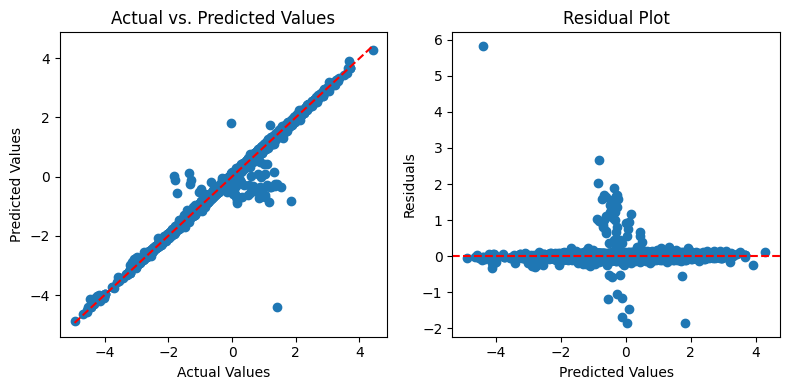

In [9]:
# First model
first_model = perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 3.0993e-03
Mean Absolute Error (MAE): 1.1689e-02
R-squared (R²) Score: 9.9060e-01
Coefficients:
-0.9951142406710717
-1.7970945526345855e-07


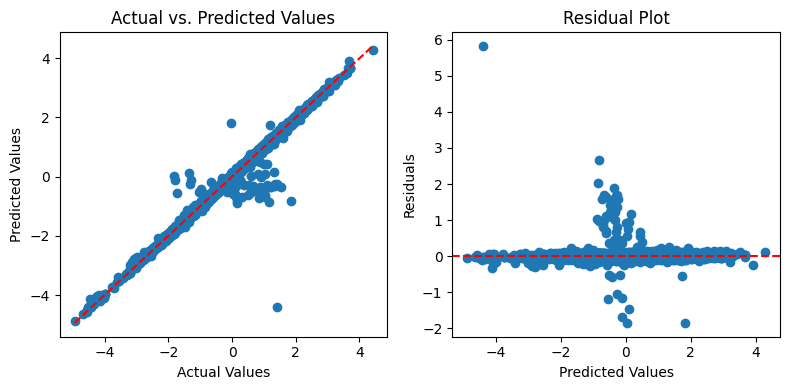

In [10]:
# Second model
second_model = perform_linear_regression(X_b, y)

In [11]:
# Save both models in a pickle file
def save_model(model, model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_5/{model_name}.pkl')
    
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)
    
    print(f'Model "{model_name}" saved to: {model_file_path}')

save_model(first_model, 'first_model')
save_model(second_model, 'second_model')



Model "first_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_5/first_model.pkl
Model "second_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_5/second_model.pkl


In [15]:
second_model.coef_

array([-9.95114241e-01, -1.79709455e-07])

In [14]:
# Get the coefficients
c_1_overline = first_model.coef_[0]
c_2_overline = first_model.coef_[1]
c_4_overline = second_model.coef_[1]

print(f'C̅₁: {c_1_overline}')
print(f'C̅₂: {c_2_overline}')
print(f'C̅₄: {c_4_overline}')
print()
# Rearange the coefficients
c_1 = c_1_overline * c_2_overline
c_2 = 1 / c_2_overline

c_4 = 1 / c_4_overline

print(f'c₁: {c_1}')
print(f'c₂: {c_2}')
print(f'c₄: {c_4}')



C̅₁: -0.9950972669344402
C̅₂: 0.00044557523673135216
C̅₄: -0.9951142406710717

c₁: -0.00044339070028503476
c₂: 2244.289892175771
c₄: -1.0049097471719766


In [13]:
c_4_overline

-1.7970945526345855e-07

In [84]:

# Rearange the coefficients
c_1 = c_1_overline * c_2_overline
c_2 = 1 / c_2_overline

c_4 = 1 / c_4_overline
#c_3 = c_3_overline * c_4
#c_5 = c_5_overline * c_4

print(f'c₁: {c_1}')
print(f'c₂: {c_2}')
print(f'c₄: {c_4}')



c₁: -0.00044339070028503476
c₂: 2244.289892175771
c₄: -5564537.483762193
